# 利用 IKEA 傢俱產品資料進行商品特價預測

## 前言

> 本文使用 Kaggle 上之IKEA 傢俱產品型錄數據，內含商品ID、商品名稱、商品種類、商品原定價及活動價等資訊，因為此資料集看不出消費者輪廓，難做到開源的角色，`所以本次分析將著重在節流的部分，針對產品特價進行預測`，欲預測下次公司舉辦促銷活動時，哪些產品應該列入活動中；哪些則直接以原定價上線即可，`使公司避免商品內折的情況`。

資料集來源 : https://www.kaggle.com/datasets/ahmedkallam/ikea-sa-furniture-web-scraping

## [ 資料前處理 ]

### 導入工具包 / 資料集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('./IKEA_SA_Furniture.csv', encoding = 'utf-8')
df = df.iloc[:,1:]  # 資料集含有index欄，故篩出index欄外的其他資料
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [3]:
df.tail()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
3689,99157902,ELVARLI,Wardrobes,750.0,SR 820,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 92x51x222-350 cm",Ehlén Johansson,50.0,NaN,91.0
3690,9158152,ELVARLI,Wardrobes,1572.0,"SR 1,755",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 135x51x222-350 cm",Ehlén Johansson,50.0,NaN,135.0
3691,59157541,ELVARLI,Wardrobes,924.0,"SR 1,050",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0
3692,89157573,ELVARLI,Wardrobes,2745.0,"SR 3,130",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 178x51x222-350 cm",Ehlén Johansson,50.0,NaN,178.0
3693,69157376,ELVARLI,Wardrobes,1231.0,"SR 1,535",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0


### 資料觀察

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_id            3694 non-null   int64  
 1   name               3694 non-null   object 
 2   category           3694 non-null   object 
 3   price              3694 non-null   float64
 4   old_price          3694 non-null   object 
 5   sellable_online    3694 non-null   bool   
 6   link               3694 non-null   object 
 7   other_colors       3694 non-null   object 
 8   short_description  3694 non-null   object 
 9   designer           3694 non-null   object 
 10  depth              2231 non-null   float64
 11  height             2706 non-null   float64
 12  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(7)
memory usage: 350.0+ KB


從info，可看到此資料集中含有13欄，3694筆商品資料，其中「depth」、「height」、「width」欄含有空值，各欄位資訊如下：  
- item_id 商品id  
- name 商品名稱  
- category 商品種類  
- price 商品活動價  
- old_price 商品原定價  
- sellable_online 線上可否購買  
- link 商品連結  
- other_colors 其他顏色  
- short_description 商品簡介  
- designer  商品設計者  
- depth/height/width 商品長寬高  

### 檢查資料是否有異常

In [5]:
df.nunique() # item_id有異常

item_id              2962
name                  607
category               17
price                 979
old_price             365
sellable_online         2
link                 2962
other_colors            2
short_description    1706
designer              381
depth                 114
height                193
width                 263
dtype: int64

從nunique中可發現`「item_id」此欄位有些異常，理論上此欄應是唯一值，但卻有重複資料，故先標記。`

### 資料清洗

In [6]:
# 空值處理
print('nan value in each columns:')
print(df.isnull().sum())


nan value in each columns:
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64


In [7]:
# 以 0補值
df = df.fillna(0)

#check
print(df.isnull().sum())


item_id              0
name                 0
category             0
price                0
old_price            0
sellable_online      0
link                 0
other_colors         0
short_description    0
designer             0
depth                0
height               0
width                0
dtype: int64


從上可發現「depth」、「height」及「width」等欄位含有空值且空值數多，約佔總筆數20%以上，推測可能是因為傢俱類的商品較難測量尺寸，所以不一定會紀錄實際的商品長寬高，因此造成此三個欄位缺失值多，若直接刪除欄位會使資料量少很多，所以將其補值為0 (補值為0者代表沒有實際長/寬/高)。

**⇣ 檢查資料時有發現「item_id」此欄有異常，將其由小到大排序觀察**

In [8]:
df = df.sort_values(by = 'item_id', ascending = True)
df.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
3251,58487,FLYTTA,Trolleys,537.0,SR 895,True,https://www.ikea.com/sa/en/p/flytta-kitchen-tr...,No,"Kitchen trolley, 98x57 cm",Nicholai Wiig Hansen,0.0,86.0,57.0
1834,91415,TROFAST,Children's furniture,5.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-lid-white...,No,"Lid, 20x28 cm",Studio Copenhagen,0.0,0.0,28.0
1918,91415,TROFAST,Nursery furniture,5.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-lid-white...,No,"Lid, 20x28 cm",Studio Copenhagen,0.0,0.0,28.0
2560,102065,LYCKSELE LÖVÅS,Sofas & armchairs,495.0,No old price,True,https://www.ikea.com/sa/en/p/lycksele-loevas-m...,No,"Mattress, 140x188 cm",IKEA of Sweden,0.0,0.0,0.0
151,102065,LYCKSELE LÖVÅS,Beds,495.0,No old price,True,https://www.ikea.com/sa/en/p/lycksele-loevas-m...,No,"Mattress, 140x188 cm",IKEA of Sweden,0.0,0.0,0.0


從上可觀察到`重複的狀況來至於「商品種類不同」`所致，
即使商品id、商品名稱、商品長寬高相同，但因其商品種類不同，即被歸為不同商品，e.g. item_id:91415

In [9]:
# 重複值處理
df = df.drop_duplicates(subset = ['item_id'], keep = 'last')
df.duplicated().sum()


0

在決定應該保留還是刪除重複值時，需考量到若保留重複資料，於後續資料探勘時，這些重複資料將被一直餵入模型中，此狀況對模型運算是不好的，因此，將重複資料移除是較符合效益的，而移除重複資料，即代表著捨棄「商品種類」此一欄位，因其已失真，故後續的預測將移除此欄。

**⇣ 著重在商品內折分析，故針對「price」此欄做離群值觀察**

<AxesSubplot: >

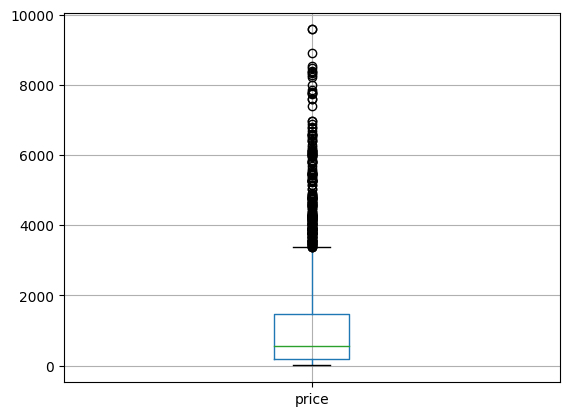

In [10]:
# "price"離群值
df.boxplot('price')

由上圖可知「price」離群值多

### 鎖定分析方向
> 本次分析著重在節流的部分，針對產品特價進行預測，欲預測下次公司舉辦促銷活動時，哪些產品應該列入活動中；哪些則直接以原定價上線即可，使公司避免商品內折的情況。

In [11]:
# 新增預測目標
df['discounted'] = (df['old_price'] != 'No old price').astype(int) ## 0代表商品沒有折扣；1代表商品有折扣

# "other_colors"欄位做編碼
df['other_colors'] = pd.Categorical(df['other_colors']).codes   ## 0代表沒有其他顏色；1代表有其他顏色

# 選定欲預測欄位
data = df[['price', 'other_colors', 'depth', 'height', 'width', 'discounted']]
data.head() 


,price,other_colors,depth,height,width,discounted
3251,537.0,0,0.0,86.0,57.0,1
1918,5.0,0,0.0,0.0,28.0,0
151,495.0,0,0.0,0.0,0.0,0
128,795.0,0,0.0,157.0,0.0,0
2687,445.0,0,0.0,75.0,37.0,0


**⇣ 針對'discounted'欄位畫分佈圖，觀察折扣商品分佈比例**

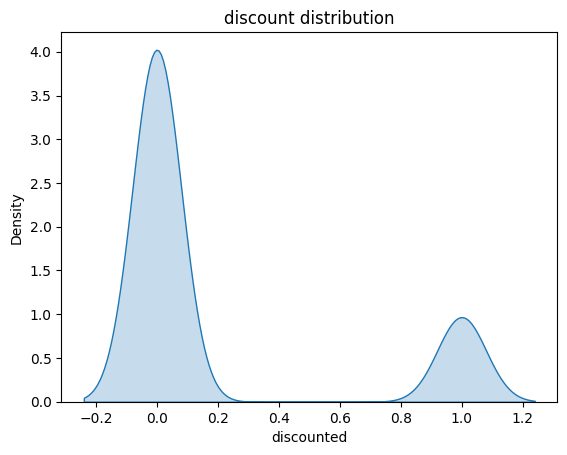

In [12]:
# 分怖圖
ax = plt.axes() ##命名一個 ax畫布
sns.kdeplot(data['discounted'], fill = 'fill', ax = ax)
ax.set_title('discount distribution')
plt.show()


「discounted」欄位，有0或1兩個選擇，兩個面積加起來為全部資料，由上分佈圖可知
`0代表商品沒有折扣；1代表商品有折扣`。商品沒有折扣的比例是有折扣的四倍，即有折扣的商品佔整體的20%

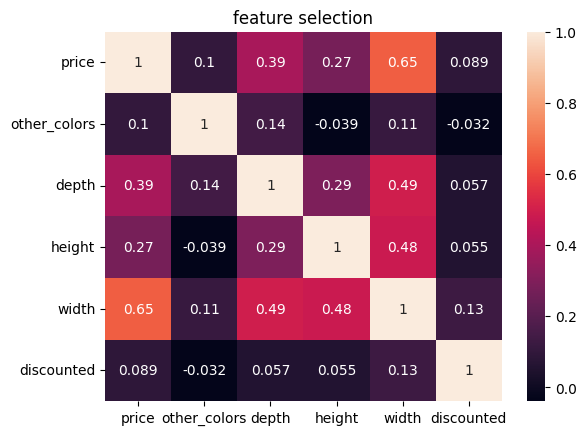

In [13]:
# 相關性
cor = data.corr()
ax = plt.axes()
sns.heatmap(cor, ax = ax, annot = True)
ax.set_title('feature selection')
plt.show()


根據相關係數熱力圖，意外的發現，原始價格跟商品的寬度有高度線性相關

### 初步結論

透過ikea約3000個商品型錄資料，得出以下分析結論:
1. 有修改過價格的產品占整體2成
2. 原始價格與商品寬度有較強的關係

接著將繼續以預測商品是否需打折為方向進行分析

## [ 開始預測 ]

In [14]:
# 導入工具包
from sklearn import preprocessing, svm, ensemble
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score
from sklearn.model_selection import train_test_split


In [15]:
# 設定特徵向量X及對應的標籤y
y = data['discounted']
X = data.drop(['discounted'], axis = 1)
print(X.shape)
print(y.shape)


(2962, 5)
(2962,)


In [16]:
# 將資料分成訓練資料及測試資料
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

# 標準化訓練資料及測試資料
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### SVM - 預測

In [17]:
# 定義SVM模型並訓練
svm_model = svm.SVC(kernel = 'rbf', C = 1, gamma = 'auto')
svm_model.fit(X_train,y_train)

y_pred = svm_model.predict(X_test)

# 驗證結果
num_correct_samples = accuracy_score(y_test, y_pred, normalize = False)
accuracy = accuracy_score(y_test, y_pred)
con_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'number of correct sample: {num_correct_samples}')
print(f'accuracy: {accuracy}')
print(f'confusion matrix: {con_matrix}')  ## y軸:真實 x軸:預測
print(f'precision score of RandomForest: {precision}')
print(f'recall score of RandomForest: {recall}')


number of correct sample: 480
accuracy: 0.8094435075885329
confusion matrix: [[475   2]
 [111   5]]
precision score of RandomForest: 0.7142857142857143
recall score of RandomForest: 0.04310344827586207


### 隨機森林 - 預測

In [18]:
# 定義RandomForest模型並訓練
forest_model = ensemble.RandomForestClassifier(n_estimators = 100)
forest_model.fit(X_train,y_train)

y_pred = forest_model.predict(X_test)

# 驗證結果
num_correct_samples = accuracy_score(y_test, y_pred, normalize = False)
accuracy = accuracy_score(y_test, y_pred)
con_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'number of correct sample: {num_correct_samples}')
print(f'accuracy: {accuracy}')
print(f'confusion_matrix: {con_matrix}')  ## y軸:真實 x軸:預測
print(f'precision score of RandomForest: {precision}')
print(f'recall score of RandomForest: {recall}')


number of correct sample: 512
accuracy: 0.863406408094435
confusion_matrix: [[460  17]
 [ 64  52]]
precision score of RandomForest: 0.7536231884057971
recall score of RandomForest: 0.4482758620689655


### XGB - 預測

In [19]:
# 定義xgboost模型並訓練
xgb_model = XGBClassifier(n_estimators = 100, learning_rate = 0.3)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# 驗證結果
num_correct_samples = accuracy_score(y_test, y_pred, normalize = False)
accuracy = accuracy_score(y_test, y_pred)
con_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'number of correct sample: {num_correct_samples}')
print(f'accuracy: {accuracy}')
print(f'confusion_matrix: {con_matrix}')  ## y軸:真實 x軸:預測
print(f'precision score of RandomForest: {precision}')
print(f'recall score of RandomForest: {recall}')


number of correct sample: 527
accuracy: 0.8887015177065767
confusion_matrix: [[467  10]
 [ 56  60]]
precision score of RandomForest: 0.8571428571428571
recall score of RandomForest: 0.5172413793103449


### 結論

上面3個模型，若由accuracy score（準確度）評估，可以很明顯的發現，在商品是否需要折扣的判定預測中，隨機森林模型及XGBoosting模型表現得比較好一點；而SVM模型則表顯得較不理想，從confusion_matrix（混淆矩陣）中可看到，造成其準確度低的主因是矩陣左下方的部分，即「商品實際上有折扣卻誤判為無折扣」，若要改善此情形，可以嘗試增加相關的資料集，亦即增加實際有打折的資料餵入模型中。

## [模型輸出 / 餵新資料預測]

**⇣ XGBoosting模型準確度較高將其輸出**

In [20]:
# 模型輸出
import joblib
joblib.dump(xgb_model, './xgb_model')


['./xgb_model']

In [21]:
# 輸入模型
loaded_model = joblib.load('./xgb_model')

# 餵新資料預測
new = {'price':[500], 'other_colors':[0], 'depth':[20],
       'height':[10], 'width':[30]}
new = pd.DataFrame(new)
print(new)
print('==========')

new_predict = loaded_model.predict(new)
print(f'新餵入資料是否需打折:{new_predict}(0代表商品不需要打折；1代表商品需打折)')


   price  other_colors  depth  height  width
0    500             0     20      10     30
新餵入資料是否需打折:[1](0代表商品不需要打折；1代表商品需打折)
